### Install OpenAI API

First, let's install the OpenAI API

In [ ]:
!pip install --upgrade openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 1.0 MB/s eta 0:00:00


# Auto Prompt

## Null Prompting

In [1]:
import pandas as pd

df = pd.read_csv('/content/createdclassification.csv')
df_test = df[0:50]
df_test

FileNotFoundError: [Errno 2] No such file or directory: '/content/createdclassification.csv'

In [ ]:
import openai
import pandas as pd
from sklearn.metrics import accuracy_score

# Initialize the OpenAI API with your key
openai.api_key = 'Open_AI_key'

count = 0
predictions = {}

# Assuming df_test has columns 'HPO_description' and 'mention'
def verify_match(row):
    global count
    prompt = f"Match: {row['mention']} Description: {row['hpo_definition']} Correct based on HPO?"
    response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",  # Use GPT-3.5 Turbo
            messages = [{"role":"user","content":prompt}],
            temperature=0,  # Set the temperature to 0 for deterministic output
        )
    answer = response.choices[0].message['content'].strip().lower()
    print(count)
    print(f"Answer is: {answer}")
    pred = 1 if answer == 'yes' else 0
    predictions[prompt] = pred
    count += 1
    return pred

# Apply the function to each row in the dataframe
df_test['is_match'] = df_test.apply(verify_match, axis=1)





## Generating Prompts

In [ ]:
# Task-1 : Generate Prompts

import pandas as pd
from sklearn.metrics import accuracy_score
import openai

# Set your OpenAI API key
api_key = "Open_AI_key"

# Initialize the OpenAI API client
openai.api_key = api_key

# Load your dataset into a DataFrame (replace 'your_data.csv' with your actual data file)
data = df_test
# Extract the features (X) and the target variable (y)
X = data[['location', 'mention', 'hpo_id', 'hpo_name', 'hpo_definition']]
y = data['label']

# Store generated prompts in a list
generated_prompts = []
count = 0

# Iterate through each row in the dataset
for index, row in X.iterrows():
    # Get the mention and description from the current row
    mention = row['mention']
    description = row['hpo_definition']

    # Create prompts
    input_text = f"Generate a short instruction prompt that asks a question to the model explicitly to match Patient's {mention} with the Human Phenotype Ontology {description}. Remember we want an answer in Yes or No. Be precise."



     # Generate response from GPT-3.5 Turbo
    response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",  # Use GPT-3.5 Turbo
            messages = [{"role":"user","content":input_text}],
            temperature=0,  # Set the temperature to 0 for deterministic output
        )
        # Add prompts to the list
    answer = response.choices[0].message['content']
    generated_prompts.append(answer)
    print(count)
    count = count+1

print(len(generated_prompts))



# Task-2: Test generated prompts and calculate accuracy
accuracy = 0
total_prompts = len(generated_prompts)

# Lists to store the matches and mismatches
matches = []
mismatches = []

for index, prompt in enumerate(generated_prompts):
    # Concatenate the mention and prompt to form the input text for GPT-3.5 Turbo
    input_text = prompt

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",  # Use the text-davinci-003 model for testing prompts
        messages = [{"role":"user","content":input_text}],
        temperature=0,  # Set the temperature to 0 for deterministic output
        #max_tokens=1  # Generate a single token response
    )

    # Convert 'Yes' to 1 and everything else to 0
    answer = response.choices[0].message['content']
    answer = 1 if answer.lower() == 'yes' else 0
    print(answer)

    # Compare the predicted answer with the ground truth label
    if answer == y[index]:
        accuracy += 1
        matches.append(index)  # Add index to the matches list
    else:
        mismatches.append(index)  # Add index to the mismatches list

    print(f"Processed prompt {index + 1}/{total_prompts}")

# Calculate and print the accuracy
final_accuracy = accuracy / total_prompts
print(f"Total Accuracy: {final_accuracy:.2%}")

# Print the list of matches and mismatches
print("Matches:", matches)
print("Mismatches:", mismatches)

In [ ]:
import matplotlib.pyplot as plt

# Calculate accuracy
accuracies = [final_accuracy]

# Plotting the accuracy graph
plt.figure(figsize=(10, 6))
colors = ['blue']

bars = plt.bar(range(len(accuracies)), accuracies, align='center', color=colors[:len(accuracies)])
plt.xticks(range(len(accuracies)), ['Generated Prompts'])

prompt_legend = ["Generated Prompts"]
plt.legend(bars, prompt_legend, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.title('Accuracy of Generated Prompts')
plt.xlabel('Prompt Type')
plt.ylabel('Accuracy')

plt.ylim(0, 1)  # Set y-axis limits to 0-1 for percentage
plt.subplots_adjust(right=0.75)
plt.savefig('accuracy_plot.png', dpi=300, bbox_inches='tight')

plt.show()


# Combining Everything

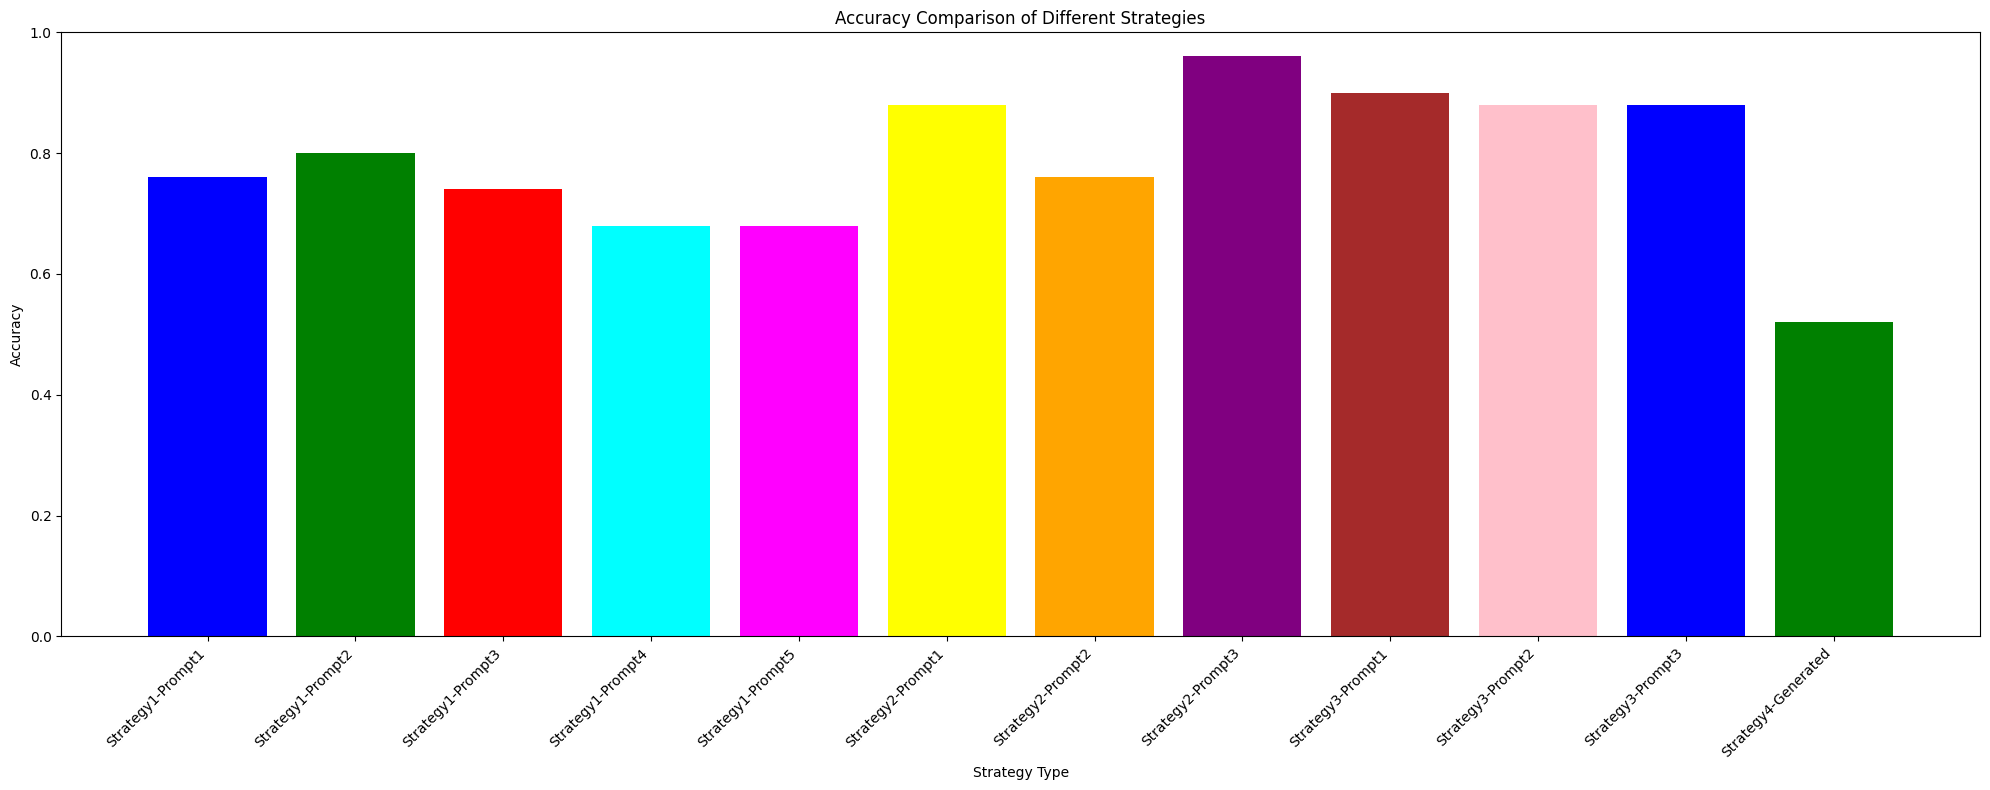

In [ ]:
import matplotlib.pyplot as plt

strategy1 = [0.76, 0.8, 0.74, 0.68, 0.68]
strategy2 = [0.88, 0.76, 0.96]
strategy3 = [0.9, 0.88, 0.88]
strategy4 = [0.52]

all_accuracies = strategy1 + strategy2 + strategy3 + strategy4

labels = [f"Strategy1-Prompt{i+1}" for i in range(len(strategy1))] + \
         [f"Strategy2-Prompt{i+1}" for i in range(len(strategy2))] + \
         [f"Strategy3-Prompt{i+1}" for i in range(len(strategy3))] + \
         ['Strategy4-Generated']

plt.figure(figsize=(20, 8))
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'orange', 'purple', 'brown', 'pink']

bars = plt.bar(range(len(all_accuracies)), all_accuracies, align='center', color=colors[:len(all_accuracies)])
plt.xticks(range(len(all_accuracies)), labels, rotation=45, ha='right')

plt.title('Accuracy Comparison of Different Strategies')
plt.xlabel('Strategy Type')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig('combined_accuracy_plot.png', dpi=300, bbox_inches='tight')
plt.show()
